<a href="https://colab.research.google.com/github/leandrodmf/ANVISA_forecast_DT_Raw/blob/main/ANVISA_forecast_DT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import pandas as pd
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1. Data organization

In [38]:
df = pd.read_csv('MEDS_OPEN_DATA.csv')
data = df[['PROCESS_FINALIZATION_DATE', 'REGULATORY_CATEGORY', 'THERAPEUTIC_CLASS']].copy()
data.rename(columns={'PROCESS_FINALIZATION_DATE': 'date','REGULATORY_CATEGORY': 'category','THERAPEUTIC_CLASS': 'class'}, inplace=True)
# df.head()

### 1.1 Treating with Missing Data

In [39]:
print(data.info())
print(data.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31317 entries, 0 to 31316
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      30799 non-null  object
 1   category  29440 non-null  object
 2   class     31236 non-null  object
dtypes: object(3)
memory usage: 734.1+ KB
None
date         518
category    1877
class         81
dtype: int64


In [40]:
data.dropna(inplace=True)
print(data.isnull().sum())

date        0
category    0
class       0
dtype: int64


In [41]:
data['date'] = pd.to_datetime(data['date'], format = '%d/%m/%Y', errors='coerce')
data.dropna(subset=['date'], inplace=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 28846 entries, 0 to 31316
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      28846 non-null  datetime64[ns]
 1   category  28846 non-null  object        
 2   class     28846 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 901.4+ KB
None


### 1.2 CLASS Organization

In [42]:
stop_words = set(stopwords.words('portuguese'))

def clean_text(text):
  text = str(text).lower()
  text = text.replace('+', '')
  text = ''.join(c for c in text if c.isalpha() or c.isspace())
  text = ' '.join([word for word in text.split() if word not in stop_words])
  return text

data['class'] = data['class'].apply(clean_text)


In [43]:
all_words = ' '.join([str(texto) for texto in data['class']])
# all_words

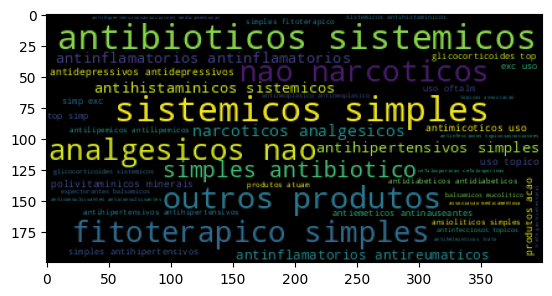

In [44]:
class_wc = WordCloud().generate(all_words)
plt.figure()
plt.imshow(class_wc)
plt.show()

# 2. Data Evaluation

In [45]:
# Time series
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['quarter'] = data['date'].dt.quarter

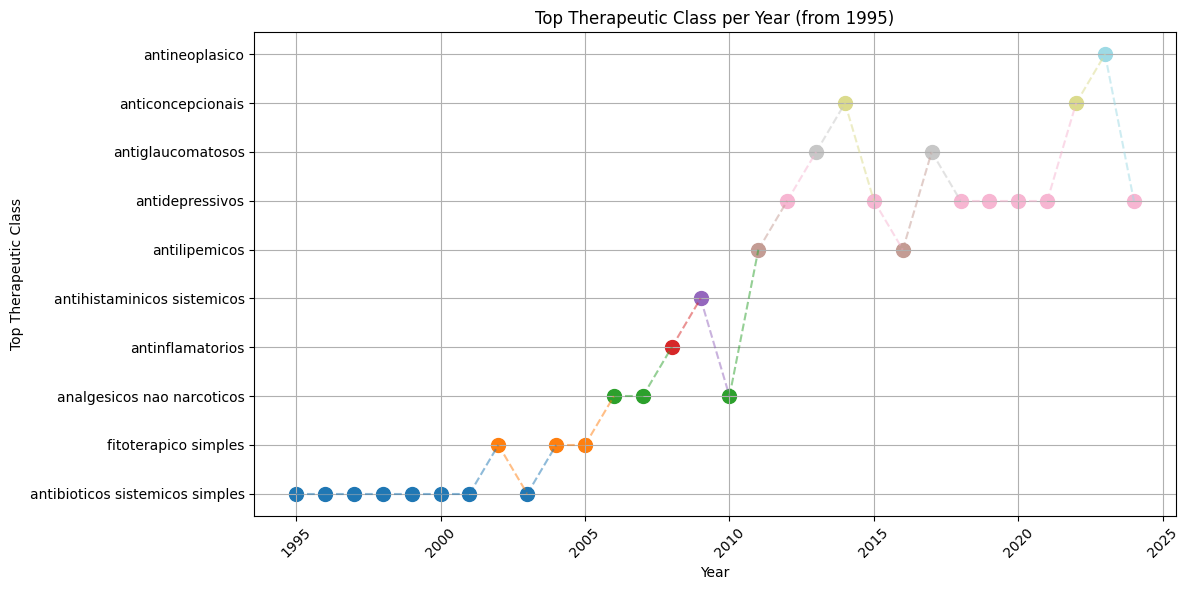

In [46]:
# TOP Terapeutic Class

data_filtered = data[data['date'].dt.year >= 1995]
top_class_by_year = data_filtered.groupby('year')['class'].agg(lambda x: x.value_counts().index[0]).reset_index()

unique_classes = top_class_by_year['class'].unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_classes)))
class_color_map = {cls: colors[i] for i, cls in enumerate(unique_classes)}

plt.figure(figsize=(12, 6))

for year, cls in zip(top_class_by_year['year'], top_class_by_year['class']):
    plt.scatter(year, cls, color=class_color_map[cls], s=100)

for i in range(len(top_class_by_year)-1):
    year1, cls1 = top_class_by_year.iloc[i][['year', 'class']]
    year2, cls2 = top_class_by_year.iloc[i+1][['year', 'class']]
    plt.plot([year1, year2], [cls1, cls2], color=class_color_map[cls1], linestyle='--', alpha=0.5)

plt.xlabel('Year')
plt.ylabel('Top Therapeutic Class')
plt.title('Top Therapeutic Class per Year (from 1995)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# 3. Forecasting

### 3.1 DecisionTree Model

In [47]:
grouped_data = data_filtered.groupby(['year', 'month', 'category', 'class']).size().reset_index(name='count')
# grouped_data.head()

In [48]:
grouped_data['category'].value_counts()

,count
category,
SIMILAR,8885
GENÉRICO,4943
NOVO,2572
ESPECÍFICO,1043
FITOTERÁPICO,735
BIOLÓGICO,591
DINAMIZADO,81
RADIOFÁRMACO,28
PRODUTO DE T,4


In [49]:
le = LabelEncoder()
grouped_data['class_encoded'] = le.fit_transform(grouped_data['class'])
grouped_data['category_encoded'] = le.fit_transform(grouped_data['category'])
# grouped_data.head()

In [50]:
x = grouped_data[['year', 'month', 'category_encoded', 'class_encoded']]
y = grouped_data['count']

In [51]:
# Spliting data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.15, random_state = 5)
x_train2, x_val, y_train2, y_val = train_test_split(x_train, y_train, test_size = 0.30, random_state = 5)

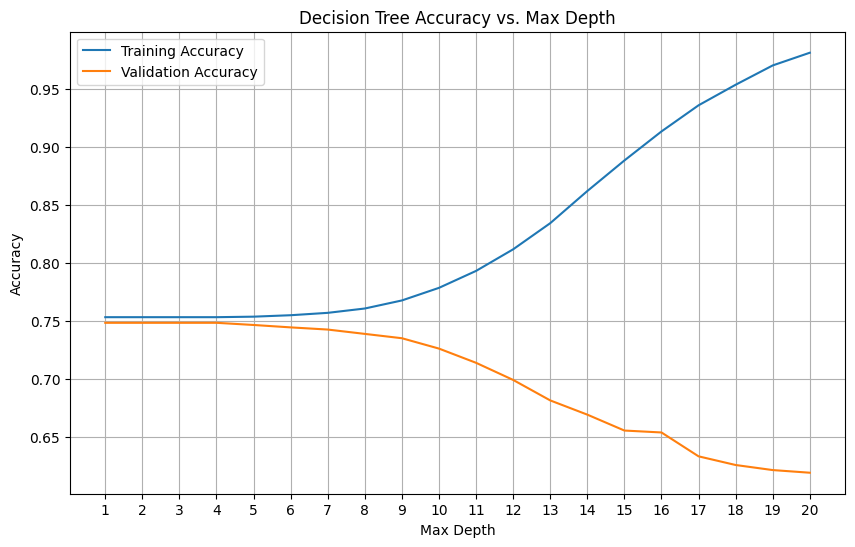

In [52]:
def evaluate_max_depth(x_train, y_train, x_val, y_val):
    train_accuracy = []
    validation_accuracy = []
    max_depths = range(1, 21)  # Evaluate max_depth from 1 to 20

    for depth in max_depths:
        dt_model_eval = DecisionTreeClassifier(max_depth=depth)
        dt_model_eval.fit(x_train2, y_train2)
        train_accuracy.append(dt_model_eval.score(x_train2, y_train2))
        validation_accuracy.append(dt_model_eval.score(x_val, y_val))

    plt.figure(figsize=(10, 6))
    plt.plot(max_depths, train_accuracy, label='Training Accuracy')
    plt.plot(max_depths, validation_accuracy, label='Validation Accuracy')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.title('Decision Tree Accuracy vs. Max Depth')
    plt.xticks(max_depths)
    plt.legend()
    plt.grid(True)
    plt.show()

evaluate_max_depth(x_train2, y_train2, x_val, y_val)

In [53]:
# Hyperparameter Tuning

param_dist = {'criterion': ['gini','entropy'],
              'max_depth': randint(1,20)}

dt_model_cv = DecisionTreeClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(dt_model_cv,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5,
                                 scoring='accuracy',
                                 random_state=42)

rand_search.fit(x_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=5,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7d3c8d8fbf90>},
                   random_state=42, scoring='accuracy')

In [54]:
rand_search.best_params_

{'criterion': 'gini', 'max_depth': 7}

In [69]:
dt_model = DecisionTreeClassifier(**rand_search.best_params_)
dt_model.fit(x_train2, y_train2)
print(f'Train accuracy: {dt_model.score(x_train, y_train):.4f}')


Train accuracy: 0.7528


In [76]:
y_pred = dt_model.predict(x_test)

print(f'Train Accuracy: {dt_model.score(x_train, y_train):.4f}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred, average="weighted", zero_division=0):.4f}')
print(f'Recall: {recall_score(y_test, y_pred, average="weighted", zero_division=0):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred, average="weighted", zero_division=0):.4f}')

Train Accuracy: 0.7528
Test Accuracy: 0.7579
Precision: 0.6162
Recall: 0.7579
F1-score: 0.6628


In [67]:
# Testing Random Florest model

from sklearn.ensemble import RandomForestClassifier

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=8)
rf_model.fit(x_train2, y_train2)

# Evaluate the model
# print(f'Train accuracy: {rf_model.score(x_train, y_train)}')
y_pred_rf = rf_model.predict(x_test)

print(f'Train Accuracy: {rf_model.score(x_train, y_train):.4f}')
print(f'Test Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}')
print(f'Precision: {precision_score(y_test, y_pred_rf, average="weighted", zero_division=1):.4f}')
print(f'Recall: {recall_score(y_test, y_pred_rf, average="weighted", zero_division=1):.4f}')
print(f'F1-score: {f1_score(y_test, y_pred_rf, average="weighted", zero_division=1):.4f}')


Train Accuracy: 0.9113
Test Accuracy: 0.7158
Precision: 0.6308
Recall: 0.7158
F1-score: 0.6658


In [58]:
# Future Dataframe
future_years = [2025]
future_months = range(1, 13)  # All 12 months

unique_categories = grouped_data['category_encoded'].unique()
unique_classes = grouped_data['class_encoded'].unique()

future_data = []
for year in future_years:
    for month in future_months:
        for cat in unique_categories:
            for cls in unique_classes:
                future_data.append([year, month, cat, cls])

future_df = pd.DataFrame(future_data, columns=['year', 'month', 'category_encoded', 'class_encoded'])

# Prediction
future_df['predicted_count'] = dt_model.predict(future_df)

# Mapping the dictionary
category_mapping = dict(zip(grouped_data['category_encoded'], grouped_data['category']))
class_mapping = dict(zip(grouped_data['class_encoded'], grouped_data['class']))
future_df['category'] = future_df['category_encoded'].map(category_mapping)
future_df['class'] = future_df['class_encoded'].map(class_mapping)

In [59]:
future_df['predicted_count'].describe()

,predicted_count
count,72144.000000
mean,1.006293
std,0.222986
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,9.000000


In [60]:
# future_df.head()

In [61]:
filtered_future_df = future_df[future_df['predicted_count'] >= 3].reset_index(drop=True)
filtered_future_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   year              56 non-null     int64 
 1   month             56 non-null     int64 
 2   category_encoded  56 non-null     int64 
 3   class_encoded     56 non-null     int64 
 4   predicted_count   56 non-null     int64 
 5   category          56 non-null     object
 6   class             56 non-null     object
dtypes: int64(5), object(2)
memory usage: 3.2+ KB


In [62]:
filtered_future_df['category'].value_counts()

,count
category,
ESPECÍFICO,14
FITOTERÁPICO,14
BIOLÓGICO,14
DINAMIZADO,14


In [72]:
all_words2 = ' '.join([str(texto) for texto in filtered_future_df['class']])
class_wc2 = WordCloud().generate(all_words2)

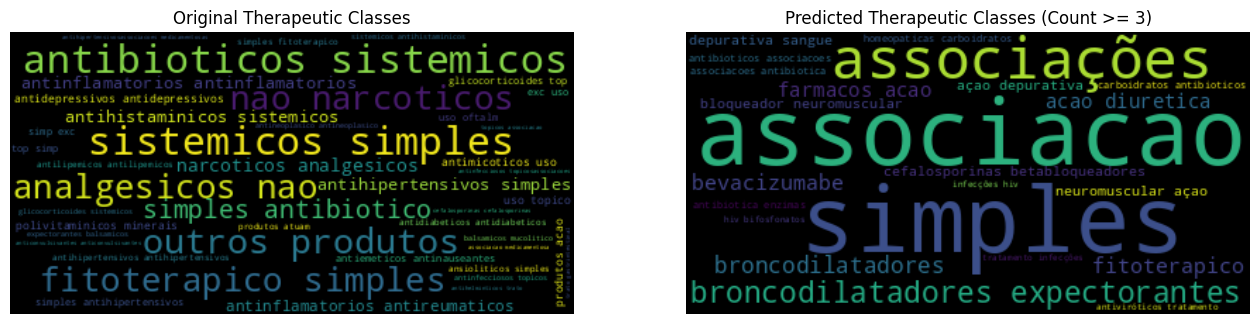

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

axes[0].imshow(class_wc, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Original Therapeutic Classes')

axes[1].imshow(class_wc2, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Predicted Therapeutic Classes')

plt.show()
